# User agent rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 30

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct user agent to device matrix

In [6]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,abroad-android,terrestrial-mac,LAPTOP-1I501C4U,boundless-mac,simon-macpro,languid-mac,serotinal-mac,dramatic-mac,essential-mac,dgmac,...,daniel-chromebook,misskitty-mac,rarb-mac,traverses-mac,turing-chromebook,appropriate-android,essential-cb,calcannea-cb,nervings-cb,score
Software%20Update (unknown ver,0,0,0,40,12,1,6,10,0,0,...,0,4,7,10,0,0,0,0,0,119
Adobe GC 1.0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Python-urllib/3.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
Java/1.8.0_171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Mozilla/5.0 (Windows NT 10.0;,0,0,925,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1859
ACC_2.00.3024_14DEDD13CDF255FA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Mozilla/5.0 (X11; Linux x86_64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Advanced Mac Cleaner/1.14.5 Sp,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
Microsoft-CryptoAPI/10.0,0,0,149,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,301
Microsoft-WNS/10.0,0,0,724,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448


## Get list of highest accessed user agents by all devices

In [7]:
top_uas = df.sort_values(by="score", ascending=False).index.values[:n]
top_uas

array(['Mozilla/5.0 (Macintosh; Intel ', 'Roblox/Darwin',
       'Mozilla/5.0 (X11; CrOS x86_64 ', 'Microsoft-Delivery-Optimizatio',
       'Mozilla/5.0 EA Download Manage', 'ProtoHttp 1.3/DS 15.1.2.3.0 (A',
       'python-requests/2.13.0', 'Mozilla/5.0 (X11; Ubuntu; Linu',
       'trustd (unknown version) CFNet', 'Mozilla/5.0 (Linux; Android 6.',
       'Mozilla/5.0 (Windows NT 10.0; ', 'Microsoft-WNS/10.0',
       'Debian APT-HTTP/1.3 (1.2.26)', 'MICROSOFT_DEVICE_METADATA_RETR',
       'ClamAV/0.100.0 (OS: darwin17.5', 'Mozilla/5.0 (Windows NT 6.1) A',
       'Microsoft-CryptoAPI/10.0', 'Safari/13605.2.8 CFNetwork/901',
       'Microsoft BITS/7.8', 'Windows-Update-Agent/10.0.1001',
       'server-bag [Mac OS X,10.13.5,1', 'dnf/2.7.5',
       'MacAppStore/2.4 (Macintosh; OS', 'Mac OS X/10.12.6 (16G1408)',
       'Microsoft BITS/7.5', 'server-bag [Mac OS X,10.12.6,1',
       'Dalvik/2.1.0 (Linux; U; Androi', 'Software%20Update (unknown ver',
       'Mac OS X/10.13.5 (17F77)', 'Microsof

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [9]:
fav_uas = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_uas

[['abroad-android',
  array(['Mozilla/5.0 (Linux; Android 8.', 'Dalvik/2.1.0 (Linux; U; Androi',
         'Software%20Update (unknown ver', 'Mozilla/5.0 (Linux; Android 6.',
         'GCSL_GCSP 3.06.1.3084', 'iTunes/12.7.5 (Macintosh; OS X',
         'mobileassetd (unknown version)', 'ACC_2.00.3024_15C2CD5AEC62D627',
         'Mac OS X/10.12.5 (16F73)', '"Mozilla/5.0 (iPhone; CPU iPho',
         '(null)/(null) (Macintosh; OS X', 'Mozilla/5.0 (X11; Fedora; Linu',
         'Windows-Update-Agent/10.0.1001', 'LookupViewService/221 CFNetwor',
         'helperamc/1.5 CFNetwork/897.15', 'ocspd/1.0.3',
         'Beyond%20Compare/4020.42.79 CF', 'Mac OS X/10.13.5 (17F77)',
         'Mozilla/5.0 (Windows NT 6.1) A', 'server-bag [Mac OS X,10.12.6,1',
         'WicaAgent', 'Spotify/107500483 (9; 0; 2)',
         'Mac OS X/10.13.4 (17E199)', 'Debian APT-HTTP/1.3 (1.6~alpha',
         'Mac OS X/10.12.6 (16G1408)', 'server-bag [Mac OS X,10.13.5,1',
         'ClamAV/0.100.0 (OS: darwin17.5', 'Mozilla/

In [10]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2

,useragents
device,
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ..."
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (..."
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (..."
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ..."
essential-mac,"[trustd (unknown version) CFNet, Software%20Up..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]

,useragents,coefficient
device,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",-2.26
rarb-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-2.83
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-2.87
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-2.88
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",-2.91
essential-mac,"[trustd (unknown version) CFNet, Software%20Up...",-2.92
nervings-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",-2.93
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-2.93
essential-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-2.93


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: spearman(uas, x)).round(2)

In [14]:
df3

,useragents,abroad-android,terrestrial-mac,LAPTOP-1I501C4U,boundless-mac,simon-macpro,languid-mac,serotinal-mac,dramatic-mac,essential-mac,...,tirasse-mac,daniel-chromebook,misskitty-mac,rarb-mac,traverses-mac,turing-chromebook,appropriate-android,essential-cb,calcannea-cb,nervings-cb
device,,,,,,,,,,,,,,,,,,,,,
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",1.00,-0.72,-3.27,-2.19,-1.37,-1.49,-0.58,-3.38,0.52,...,0.22,0.79,-2.12,-0.46,-0.86,0.11,0.99,0.39,0.39,0.79
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-0.72,1.00,-3.07,-1.60,-0.25,-0.03,-0.69,-2.71,-0.36,...,-0.40,-0.87,-1.51,0.21,-0.41,-0.34,-0.72,-0.90,-0.90,-0.87
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (...",-3.27,-3.07,1.00,-3.92,-3.01,-2.82,-2.97,-4.22,-3.25,...,-3.03,-3.25,-2.74,-3.04,-3.04,-3.02,-3.25,-3.32,-3.32,-3.25
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (...",-2.19,-1.60,-3.92,1.00,-1.01,-1.68,-2.23,-2.85,-2.01,...,-2.00,-2.39,-2.59,-1.68,-1.48,-2.21,-2.20,-2.36,-2.36,-2.39
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-1.37,-0.25,-3.01,-1.01,1.00,-0.24,-1.04,-2.62,-1.12,...,-1.00,-1.52,-2.17,-0.42,-0.56,-1.18,-1.33,-1.46,-1.46,-1.52
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-1.49,-0.03,-2.82,-1.68,-0.24,1.00,-0.90,-2.72,-1.04,...,-0.84,-1.67,-1.36,-0.33,-0.22,-0.99,-1.48,-1.59,-1.59,-1.67
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-0.58,-0.69,-2.97,-2.23,-1.04,-0.90,1.00,-3.16,-0.50,...,-0.37,-0.77,-1.34,-0.81,-1.17,-0.66,-0.57,-0.99,-0.99,-0.77
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",-3.38,-2.71,-4.22,-2.85,-2.62,-2.72,-3.16,1.00,-3.14,...,-3.06,-3.56,-3.29,-3.03,-2.96,-3.29,-3.40,-3.63,-3.63,-3.56
essential-mac,"[trustd (unknown version) CFNet, Software%20Up...",0.52,-0.36,-3.25,-2.01,-1.12,-1.04,-0.50,-3.14,1.00,...,0.77,0.33,-1.69,-0.16,-0.57,0.66,0.53,0.52,0.52,0.33


In [15]:
## Calculate log10(coefficient)
my_fn = lambda x: np.log10(x + 10)
df4 = df3.copy()
df4[all_devices] = df4[all_devices].apply(lambda x: [my_fn(v) for v in x]).round(2)

In [16]:
df4

,useragents,abroad-android,terrestrial-mac,LAPTOP-1I501C4U,boundless-mac,simon-macpro,languid-mac,serotinal-mac,dramatic-mac,essential-mac,...,tirasse-mac,daniel-chromebook,misskitty-mac,rarb-mac,traverses-mac,turing-chromebook,appropriate-android,essential-cb,calcannea-cb,nervings-cb
device,,,,,,,,,,,,,,,,,,,,,
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",1.04,0.97,0.83,0.89,0.94,0.93,0.97,0.82,1.02,...,1.01,1.03,0.90,0.98,0.96,1.00,1.04,1.02,1.02,1.03
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.97,1.04,0.84,0.92,0.99,1.00,0.97,0.86,0.98,...,0.98,0.96,0.93,1.01,0.98,0.98,0.97,0.96,0.96,0.96
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (...",0.83,0.84,1.04,0.78,0.84,0.86,0.85,0.76,0.83,...,0.84,0.83,0.86,0.84,0.84,0.84,0.83,0.82,0.82,0.83
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (...",0.89,0.92,0.78,1.04,0.95,0.92,0.89,0.85,0.90,...,0.90,0.88,0.87,0.92,0.93,0.89,0.89,0.88,0.88,0.88
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.94,0.99,0.84,0.95,1.04,0.99,0.95,0.87,0.95,...,0.95,0.93,0.89,0.98,0.97,0.95,0.94,0.93,0.93,0.93
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.93,1.00,0.86,0.92,0.99,1.04,0.96,0.86,0.95,...,0.96,0.92,0.94,0.99,0.99,0.95,0.93,0.92,0.92,0.92
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.97,0.97,0.85,0.89,0.95,0.96,1.04,0.84,0.98,...,0.98,0.97,0.94,0.96,0.95,0.97,0.97,0.95,0.95,0.97
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.82,0.86,0.76,0.85,0.87,0.86,0.84,1.04,0.84,...,0.84,0.81,0.83,0.84,0.85,0.83,0.82,0.80,0.80,0.81
essential-mac,"[trustd (unknown version) CFNet, Software%20Up...",1.02,0.98,0.83,0.90,0.95,0.95,0.98,0.84,1.04,...,1.03,1.01,0.92,0.99,0.97,1.03,1.02,1.02,1.02,1.01


## Plot it, heatmap

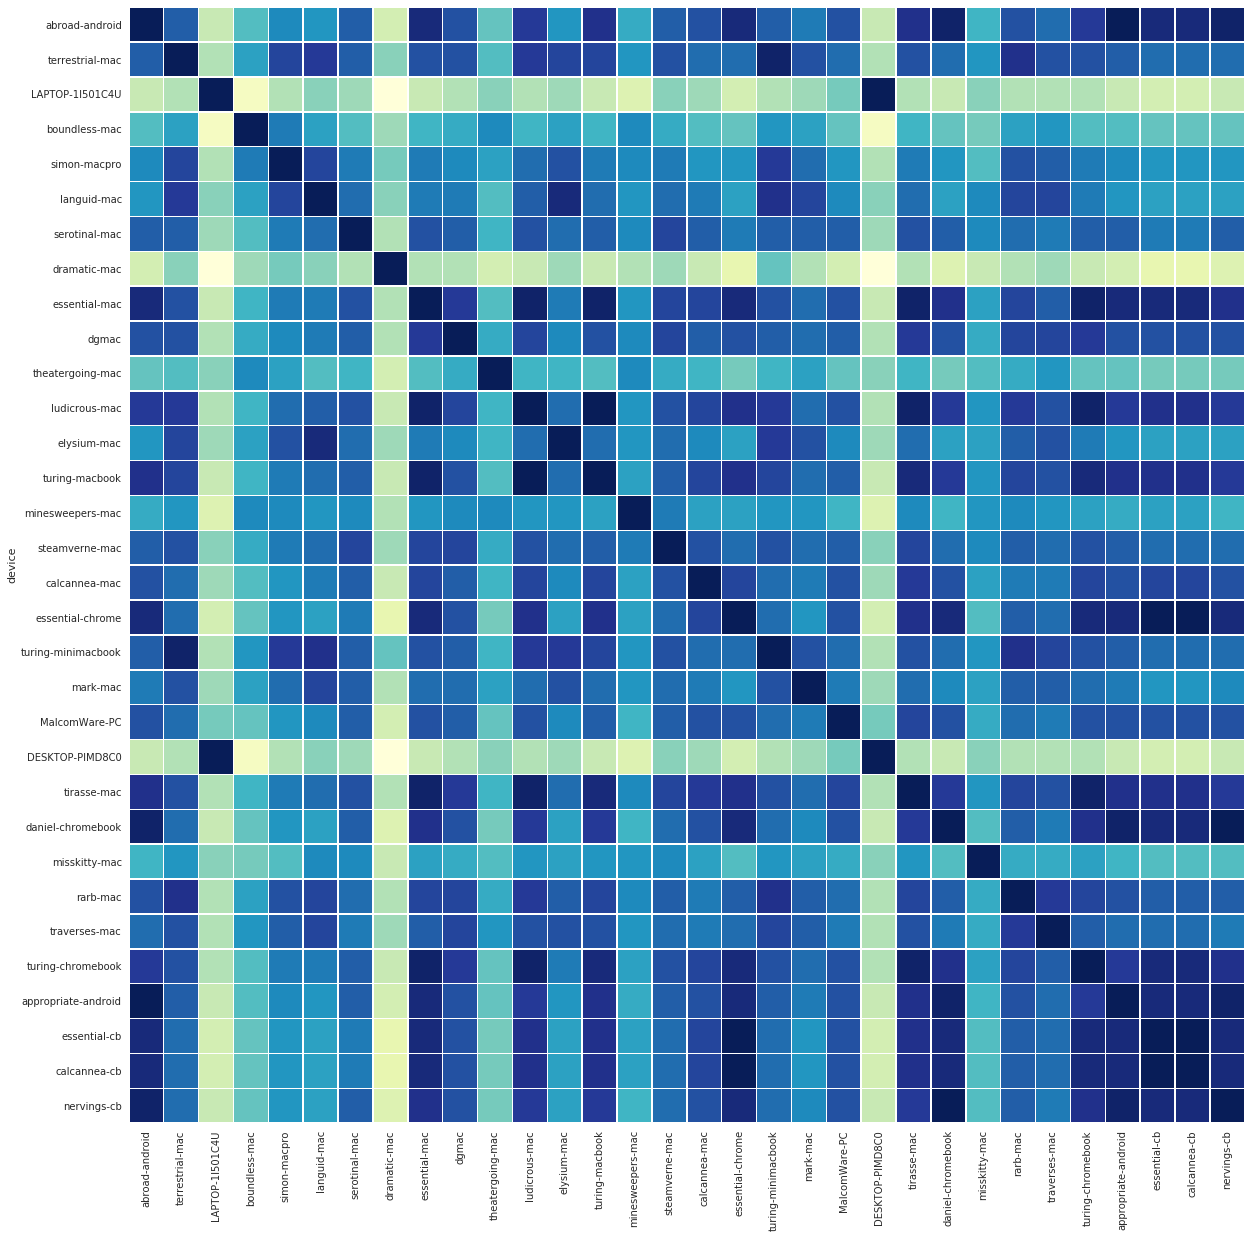

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df4[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()